In [1]:
import os
import sys
import pickle
import re

import numpy as np
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib

sys.path.append("/home/axel/mercury_orbit")
sys.path.append("/home/axel/mercury_orbit/integrators_objects/")
from integrators.euler_forward import EulerForward

from utils.integrator_object_utils import save_integrators

from scipy.signal import find_peaks
from scipy.stats import linregress

# Euler method

In [9]:
t_start = 0
t_end = 3000

M = 1
r = 9
#v = 0.345

#v = np.sqrt(M / r) + 0.01 * M / r
v = 0.375#np.sqrt(M / r) + 0.001 * M / r
initial_conditions = np.array([r, 0.0, 0, v / r])

dt_array = [0.5, 0.3, 0.1, 0.08, 0.05, 0.01]

In [8]:
t_start = 0
t_end = 2000

M = 1
r = 10 * M

#v = 0.345
v = np.sqrt(M / r) + 0.01 * M / r
initial_conditions = np.array([r, 0.0, 0, v / r])

dt_array = [0.5, 0.3, 0.1, 0.08, 0.05]

In [10]:
#plt.plot(t_array, r_array)
#ax.plot(euler_f_x_array, euler_f_y_array, "-", label="Euler forward")
#ax.plot(euler_x_array, euler_y_array, "--", label="Back Euler")
#ax.plot(rk4_x_array, rk4_y_array, "--", label="Rk4")

euler_integrators = {}

for dt in dt_array:#, 0.001]:
    print(dt)
    euler_forward_integrator = EulerForward(initial_conditions, dt, t_end, t_start, M)
    euler_forward_integrator.run_simulation()
    euler_integrators[str(dt)] = euler_forward_integrator
    t_array = np.append(euler_forward_integrator.t_array, t_end)
    # ax.plot(t_array, euler_forward_integrator.get_system_energy(), "-", label="Euler forward")


0.5
0.3
0.1
0.08
0.05
0.01


In [6]:
# save integrators
save_dir = "../integrators_objects/0375_precession_study"
save_integrators(euler_integrators, "euler_method", save_dir)

In [2]:
def save_integrators(integrators: dict, base_name: str, save_dir: str):
    for dt, integrator in euler_integrators.items():
        with open("{0}/{1}_{2}".format(save_dir, base_name, dt), "wb") as f:
            pickle.dump(integrator, f)

In [2]:
euler_integrators = {}

path = "../integrators_objects/0375_precession_study"

for file_name in os.listdir(path):
    if re.findall("euler_method", file_name):
        dt = re.findall("\d+\.\d+", file_name)[0]
        with open("{0}/{1}".format(path, file_name), "rb") as f:
            e = pickle.load(f)
            print(dt)
            euler_integrators[str(dt)] = e
            

0.3
0.08
0.5
0.05
0.1
0.01


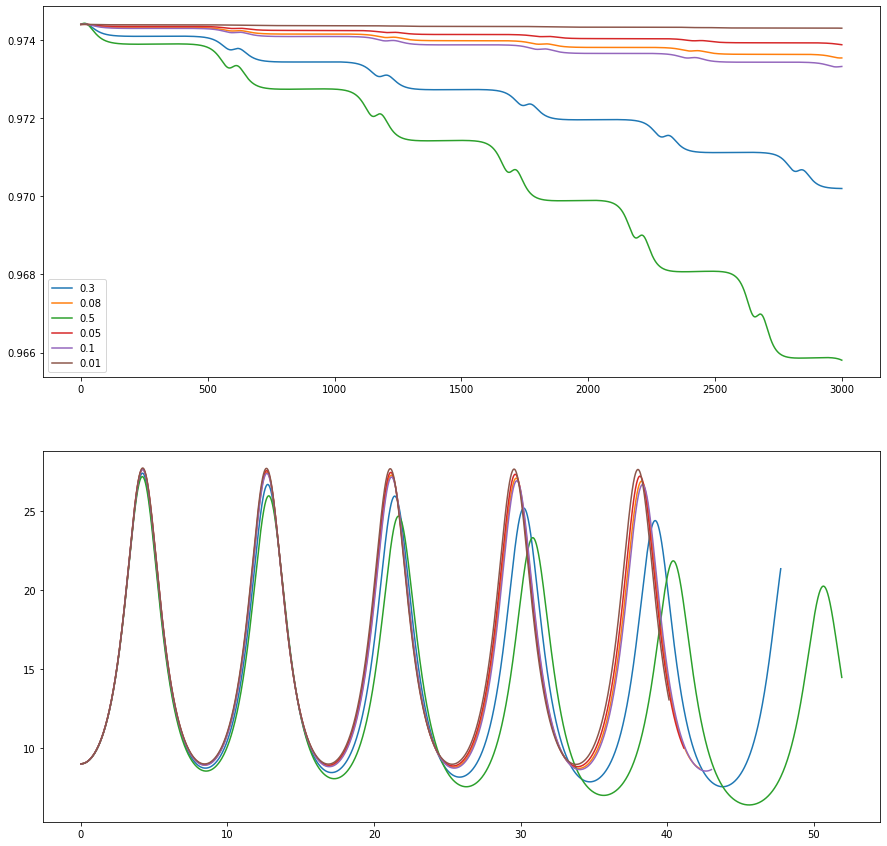

In [3]:
fig, axs = plt.subplots(2,1, figsize=(15,15))

for dt, integrator in euler_integrators.items():
    # if dt == "0.1":
    #     continue
    #axs[0].plot(np.append(integrator.t_array, t_end), integrator.get_system_energy(), label=dt)
    axs[0].plot(integrator.t_array, integrator.get_system_energy()[:-1], label=dt)
    #axs[0].plot(np.append(integrator.t_array, t_end), integrator.obs[:,2], label=dt)
    #axs[1].plot(np.append(integrator.t_array, t_end), integrator.obs[:,0], label=dt)
    axs[1].plot(integrator.obs[:,2], integrator.obs[:,0], label=dt)
    #axs[1].plot(integrator.obs[:,0]*np.cos(integrator.obs[:,2]), integrator.obs[:,0]*np.sin(integrator.obs[:,2]), label=dt)
# ax.plot(t_array, f)

axs[0].legend()

LinregressResult(slope=0.437098762684805, intercept=0.6725066154420279, rvalue=0.9920304045972606, pvalue=9.501858408716479e-05, stderr=0.027758162688930995)


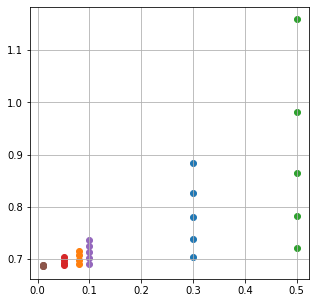

In [4]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

dts = [float(key) for key in euler_integrators.keys()]
change_avgs = []

# finding the perihelions
for dt, integrator in euler_integrators.items():
    # Finding valleys/perihelions
    peri_ind, _ = find_peaks(-integrator.obs[:,0])
    peri_ind = np.insert(peri_ind, 0, 0)
    # print(dt, integrator.obs[peri_ind, 2]/(2 * np.pi))
    change = np.diff(integrator.obs[peri_ind, 2])/np.pi - 2
    change_avg = np.mean(change)
    change_avgs.append(change_avg)
    ax.scatter([float(dt)]*len(change), change)

result = linregress(dts, change_avgs)

print(result)

ax.grid()



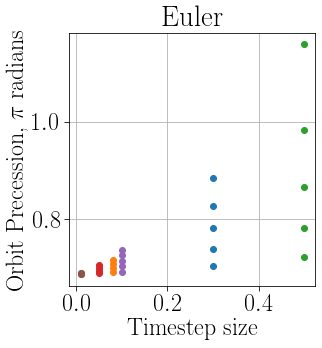

In [6]:
import utils.figure_generation
import importlib

importlib.reload(utils.figure_generation)

#for name, method_integrators in integrators.items():
title = "Euler"
fig, ax = utils.figure_generation.generate_precession_graph(euler_integrators, title)

name = "euler"
fig.savefig("../report/figures/precession_analysis/"+name, dpi=600)

dt =   0.5: a:  0.560221218175569  , b: -3.4318863032568445
dt =   0.3: a: 0.46404376037153333 , b: -3.7562935893531133
dt =   0.1: a:  0.3011499010822716 , b: -4.176399052138762
dt =  0.08: a:  0.3010806826030078 , b: -4.293065755561614
dt =  0.05: a:  0.2375770180864889 , b: -4.361858889126574


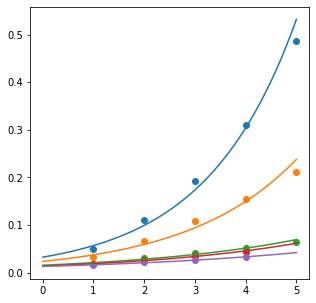

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

for dt in dt_array:
    integrator = euler_integrators[str(dt)]
    peri_ind, _ = find_peaks(-integrator.obs[:,0])
    peri_ind = np.insert(peri_ind, 0, 0)
    # print(dt, integrator.obs[peri_ind, 2]/(2 * np.pi))
    change = np.diff(integrator.obs[peri_ind, 2])/np.pi - 2
    num_orbits = range(1, len(change)+1)

    converged_precession = 0.6725

    a, b = np.polyfit(num_orbits, np.log(change - converged_precession), 1)
    print("dt = {:5}: a: {:^20}, b: {:10}".format(dt, a, b))
    x_range = np.linspace(0, 5)

    ax.scatter(num_orbits, change - converged_precession)
    ax.plot(x_range, np.exp(b) * np.exp(a*x_range))

$dt = 0.5$:
$err = e^{-3.431 +  0.56}$


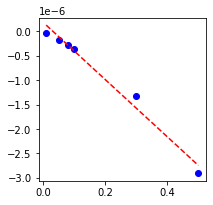

In [10]:
## INvestigating slope dependence
fig, ax = plt.subplots(1,1, figsize=(3,3))

dts = []
ks = []

for dt_str, integrator in euler_integrators.items():
    dt = float(dt_str)
    reg_result = stats.linregress(np.append(integrator.t_array, t_end), integrator.get_system_energy())
    ax.scatter(dt, reg_result.slope, label=dt, c="blue")
    
    dts.append(dt)
    ks.append(reg_result.slope)
    
reg_result = stats.linregress(dts, ks)

ks = [x for _, x in sorted(zip(dts, ks), key=lambda pair: pair[0])]
ax.plot([min(dts), max(dts)], [ks[0] + reg_result.intercept, ks[-1] + reg_result.intercept], "--r")

#generate_figure_loc(ax, fig, "figures/energy_conservation_euler_method.png")
    

# ax.legend()

# fig.savefig("report/figures/energy_conservation_euler_method.png", dpi=1000)